# Convolutional Neural Networks (CNN)

Convolutional neural networks (CNN) are powerful tools to perform image classification and segmentation. In this notebook, we explore the task of image classification using the CIFAR10 dataset.


In [1]:
%matplotlib inline

In [38]:
import datetime
from pathlib import Path
from typing import Final, Literal, Iterator


import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as nnf
from torchvision import datasets, transforms

Load the data. The image normalization is taken from the web.

In [3]:
data_path = Path("../cifar_data")

class_names: list[str] = [
    'airplane','automobile','bird','cat','deer',
    'dog','frog','horse','ship','truck'
]

# Transform statistics taken from https://stackoverflow.com/a/69750247
cifar10_preprocessor = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]
)

cifar10_train = datasets.CIFAR10(
    data_path,
    train=True,
    download=True,
    transform=cifar10_preprocessor
)

cifar10_val = datasets.CIFAR10(
    data_path,
    train=False,
    download=True,
    transform=cifar10_preprocessor
)


Files already downloaded and verified
Files already downloaded and verified


Since I got the normalization values from the Internet, I should verify that these statistics are accurate. I will create numpy batch arrays and take the mean and std along the batch and 32x32 pixel axes.

In [4]:
# use np.concatenate to stick all the images together to form a (batch, 3, 32, 32) array
imgs = np.concatenate(
    np.asarray([[
        [
            cifar10_train[i][0][0].numpy(),
            cifar10_train[i][0][1].numpy(),
            cifar10_train[i][0][2].numpy()
        ]
        for i in range(len(cifar10_train))
    ]])
)

print(imgs.shape)

(50000, 3, 32, 32)


The array has the correct shape (batch, channels, height, width).

Since the image data was normalized, we should see zero mean and standard deviation of one (1) for the three channels.

In [5]:
# calculate the mean along the (batch, pixel, pixel) axes
train_mean = np.mean(imgs, axis=(0, 2, 3))
print(train_mean)

[-0.00040607 -0.0005815  -0.00102856]


In [6]:
# calculate the std along the (batch, pixel, pixel) axes
train_std = np.std(imgs, axis=(0, 2, 3))
print(train_std)


[1.0001289  0.9999368  0.99995327]


Great! The data is normalized with zero mean and standard deviation of one (1).

Now let's use a simplified model of distinguishing birds from airplanes. Let's call this CIFAR2

In [7]:
# New class names
cifar2_class_names: list[str] = ['airplane', 'bird']

# Convert between CIFAR10 and CIFAR2
cifar10_to_2_indices: list[int] = [
    class_names.index(cifar2) for cifar2 in cifar2_class_names
]
label_map: dict[int, int] = { #{0: 0, 2: 1}
    cifar2_ind: cifar10_ind
    for (cifar10_ind, cifar2_ind) in enumerate(cifar10_to_2_indices)
}

cifar2 = [
    (img, label_map[label])
    for img, label in cifar10_train
    if label in cifar10_to_2_indices
]

cifar2_val = [
    (img, label_map[label])
    for img, label in cifar10_val
    if label in cifar10_to_2_indices
]


One of important method to avoid overtraining is the use mini-batches selected in the training. Using the PyTorch DataLoader class provides this great functionality.

In [8]:
train_loader = DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = DataLoader(cifar2_val, batch_size=64, shuffle=False)

Depending on your host, you can use nVidia GPU granted it has CUDA support and installed.

In [9]:
device: Final = (
    torch.device('cuda') if torch.cuda.is_available()
    else torch.device('cpu')
)
device

device(type='cpu')

Let's implement the training loop

In [10]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    """Run training on a CNN

    Parameters
    ----------
    n_epochs : int
        Number of training iterations
    optimizer : optim.Optimizer
        Optimizer
    model : nn.Module
        CNN model
    loss_fn : nn.Module
        Loss function module
    train_loader : DataLoader
        Batched data loader

    Returns
    -------
    None
    """
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs_t, labels_t in train_loader:
            imgs_t = imgs_t.to(device=device)
            labels_t = labels_t.to(device=device)
            outputs = model(imgs_t)
            loss = loss_fn(outputs, labels_t)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch < 4 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

Now define the validation function

In [11]:
def validate(model, train_loader, val_loader):
    """Validate model training

    Parameters
    ----------
    model : nn.Module
        Trained model module
    train_loader : DataLoader
        Training data loading
    val_loader : DataLoader
        Validation data loader

    Returns
    -------
    dict[str, float]
        Accuracy dictionary for data loaders. The keys are ["train", "val"]
    """
    accdict: dict[Literal["train", "val"], float] = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs_t, labels_t in loader:
                outputs = model(imgs_t)
                _, predicted_t = torch.max(outputs, dim=1)
                total += labels_t.shape[0]
                correct_t = predicted_t == labels_t
                correct += int(correct_t.sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

Let's define a small CNN that has 3 convolutional layers and two subsequent linear layers.

While rectified linear unit activation function is the practitioner favorite, let's continue using tanh and compare the results.

Let me include this important "gotcha" from the book. Consider some CNN model like below with the last layer with a log-softmax activation function and negative log-likelihood loss function.

```python
model = nn.Sequential(
            ...,
            nn.LogSoftmax(dim=1))
optimizer = nn.NLLLoss()
```

"_The combination of nn.LogSoftmax and nn.NLLLoss is equivalent to using nn.CrossEntropyLoss. This terminology is a particularity of PyTorch, as the nn.NLLoss computes, in fact, the cross entropy but with log probability predictions as inputs where nn.CrossEntropyLoss takes scores (sometimes called logits). Technically, nn.NLLLoss is the cross entropy between the Dirac distribution, putting all mass on the target, and the predicted distribution given by the log probability inputs._

_To add to the confusion, in information theory, up to normalization by sample size, this cross entropy can be interpreted as a negative log likelihood of the predicted distribution under the target distribution as an outcome. So both losses are the negative log likelihood of the model parameters given the data when our model predicts the (softmax-applied) probabilities. In this book, we won’t rely on these details, but don’t let the PyTorch naming confuse you when you see the terms used in the literature._

_It is quite common to drop the last nn.LogSoftmax layer from the network and use nn.CrossEntropyLoss as a loss._"

So let's keep this in mind for our application.

In [12]:
class Cifar2CNN(nn.Module):
    """CNN image classifier for two (2) classes"""

    def __init__(
        self,
        n_chans1=32
    ):
        """Instantiate a CNN CIFAR image classifier for two (2) classes.

        Parameters
        ----------
        n_chans1 : int
            Number of channels in the first layer

        """
        super().__init__()
        self.cifar_size: Final[int] = 32
        self.n_chans1: Final[int] = n_chans1
        self.cov_ker_size: Final[int] = 3
        self.cov_pad: Final[int] = 1
        # First convolutional layer (B, 3, 32, 32)
        self.conv1 = nn.Conv2d(
            3,
            n_chans1,
            self.cov_ker_size,
            padding=self.cov_pad
        )
        # Second convolutional layer, after applying pooling (B, n_chans1, 16, 16)
        self.conv2 = nn.Conv2d(
            n_chans1,
            n_chans1 // 2,
            self.cov_ker_size,
            padding=self.cov_pad
        )
        # Third convolutional layer, after applying pooling (B, n_chans1, 8, 8)
        self.conv3 = nn.Conv2d(
            n_chans1 // 2,
            n_chans1 // 2,
            self.cov_ker_size,
            padding=self.cov_pad
        )
        # Functional layer after convolutions and view/reshape (B, n_chans1 * 8 * 8, 32)
        self.fcn4 = nn.Linear(
            ((self.cifar_size // 4) ** 2) * (n_chans1 // 2),
            32
        )
        # Output functional layer after functional (B, 2)
        self.fcn5 = nn.Linear(32, 2)

    def forward(self, batch):
        """Propagate the batch forward through NN.

        Parameters
        ----------
        batch : torch.Tensor
            Batch of images

        Returns
        -------
        torch.Tensor
            Forward propagated tensor
        """
        out = nnf.max_pool2d(torch.tanh(self.conv1(batch)), 2)
        out = nnf.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, self.fcn4.in_features)
        out = torch.tanh(self.fcn4(out))
        out = self.fcn5(out)
        return out


Now let's try to train the model with a few epochs.

In [13]:
model = Cifar2CNN().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 3,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

validate(model, train_loader, val_loader)

2022-12-24 18:57:11.984444 Epoch 1, Training loss 0.5616304500467458
2022-12-24 18:57:33.222844 Epoch 2, Training loss 0.4801065959748189
2022-12-24 18:57:48.406841 Epoch 3, Training loss 0.44153597761111657
Accuracy train: 0.81
Accuracy val: 0.82


{'train': 0.8111, 'val': 0.818}

Neat! Now we have a classifier.

Let's now demonstrate how we can use regularization to prevent overtraining. Using mini-batches already helps us, but this helps put us over-the-top. We could also explore other topics like Dropout.

In [14]:
def reg_lq(param, q_val):
    """Regularization additive value for loss/objective function

    Parameters
    ----------
    param : Iterator[Parameter]
        Iterator for model parameter tensors
    q_val : float
        Hyper-parameter value of the regularization power

    Returns
    -------
    torch.Tensor
        Single item tensor for regularization term
    """
    return sum(p.pow(q_val).sum() for p in param)


def reg_l2(param):
    """L2 ridge regularization term for a loss function"""
    return reg_lq(param, 2.0)


def reg_l1(param):
    """L2 euclidean regularization term for a loss function"""
    return reg_lq(param, 1.0)


def reg_elastic_net(param, scale):
    """Use elastic-net regularization as defined by 'Statistical Learning
    with Sparsity' by Hastie et al. where the hyperparameter scale is
    bounded [0, 1]"""
    assert 0 <= scale <= 1
    return 0.5 * (1.0 - scale) * reg_l2(param) + scale * reg_l1(param)


def training_loop_reg(
    n_epochs,
    optimizer,
    model,
    loss_fn,
    reg_fn,
    reg_scale,
    train_loader):
    """Run training on a CNN including regularization function

    Parameters
    ----------
    n_epochs : int
        Number of training iterations
    optimizer : optim.Optimizer
        Optimizer
    model : nn.Module
        CNN model
    loss_fn : nn.Module
        Loss function module
    reg_fn : Callable
        Regularization function
    reg_scale : float
        Regularization scale
    train_loader : DataLoader
        Batched data loader

    Returns
    -------
    None
    """
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs_t, labels_t in train_loader:
            imgs_t = imgs_t.to(device=device)
            labels_t = labels_t.to(device=device)
            outputs = model(imgs_t)
            loss = loss_fn(outputs, labels_t)
            reg = reg_fn(model.parameters())
            loss += reg_scale * reg
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch <= 5 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [15]:
model_l2 = Cifar2CNN().to(device=device)
optimizer_l2 = optim.SGD(model_l2.parameters(), lr=1e-2)

training_loop_reg(
    n_epochs = 5,
    optimizer = optimizer_l2,
    model = model_l2,
    loss_fn = nn.CrossEntropyLoss(),
    reg_fn = reg_l2,
    reg_scale = 1e-2,
    train_loader = train_loader,
)

validate(model_l2, train_loader, val_loader)

2022-12-24 18:58:13.749854 Epoch 1, Training loss 0.891587048199526
2022-12-24 18:58:26.128424 Epoch 2, Training loss 0.800827813376287
2022-12-24 18:58:38.200783 Epoch 3, Training loss 0.7578018478527191
2022-12-24 18:58:51.058846 Epoch 4, Training loss 0.7155574825918598
2022-12-24 18:59:03.162665 Epoch 5, Training loss 0.6751801382963825
Accuracy train: 0.83
Accuracy val: 0.83


{'train': 0.8264, 'val': 0.83}

In [18]:
model_l1 = Cifar2CNN().to(device=device)
optimizer_l1 = optim.SGD(model_l1.parameters(), lr=1e-2)

training_loop_reg(
    n_epochs = 5,
    optimizer = optimizer_l1,
    model = model_l1,
    loss_fn = nn.CrossEntropyLoss(),
    reg_fn = reg_l1,
    reg_scale = 1e-3,
    train_loader = train_loader,
)

validate(model_l1, train_loader, val_loader)

2022-12-24 19:01:55.947694 Epoch 1, Training loss 0.5086852414592816
2022-12-24 19:02:08.055812 Epoch 2, Training loss 0.3720988658772912
2022-12-24 19:02:20.065492 Epoch 3, Training loss 0.2807901417184028
2022-12-24 19:02:32.114762 Epoch 4, Training loss 0.1881754591966131
2022-12-24 19:02:42.999169 Epoch 5, Training loss 0.09886595957977756
Accuracy train: 0.84
Accuracy val: 0.84


{'train': 0.8401, 'val': 0.8435}

In [17]:
model_elnet = Cifar2CNN().to(device=device)
optimizer_elnet = optim.SGD(model_elnet.parameters(), lr=1e-2)

training_loop_reg(
    n_epochs = 5,
    optimizer = optimizer_elnet,
    model = model_elnet,
    loss_fn = nn.CrossEntropyLoss(),
    reg_fn = lambda p: reg_elastic_net(p, 0.5),
    reg_scale = 1e-2,
    train_loader = train_loader,
)

validate(model_elnet, train_loader, val_loader)

2022-12-24 19:00:32.255039 Epoch 1, Training loss 0.6479917732393665
2022-12-24 19:00:43.842145 Epoch 2, Training loss 0.5564538099963194
2022-12-24 19:00:55.035652 Epoch 3, Training loss 0.5185174579453317
2022-12-24 19:01:06.925580 Epoch 4, Training loss 0.4817211168586828
2022-12-24 19:01:19.173259 Epoch 5, Training loss 0.45180436949821035
Accuracy train: 0.84
Accuracy val: 0.84


{'train': 0.8419, 'val': 0.8365}

Let's test the result on an independent image of a B-2 bomber.

In [34]:
!wget https://wallpapercave.com/dwp1x/SpSZG7Z.jpg
!mv SpSZG7Z.jpg cifar_data

--2022-12-24 19:14:52--  https://wallpapercave.com/dwp1x/SpSZG7Z.jpg
Resolving wallpapercave.com (wallpapercave.com)... 2606:4700:10::6816:3447, 2606:4700:10::6816:3547, 2606:4700:10::ac43:1d1a, ...
Connecting to wallpapercave.com (wallpapercave.com)|2606:4700:10::6816:3447|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30649 (30K) [image/jpeg]
Saving to: ‘SpSZG7Z.jpg’

SpSZG7Z.jpg         100%[===================>]  29.93K  --.-KB/s    in 0.008s  

2022-12-24 19:14:52 (3.70 MB/s) - ‘SpSZG7Z.jpg’ saved [30649/30649]



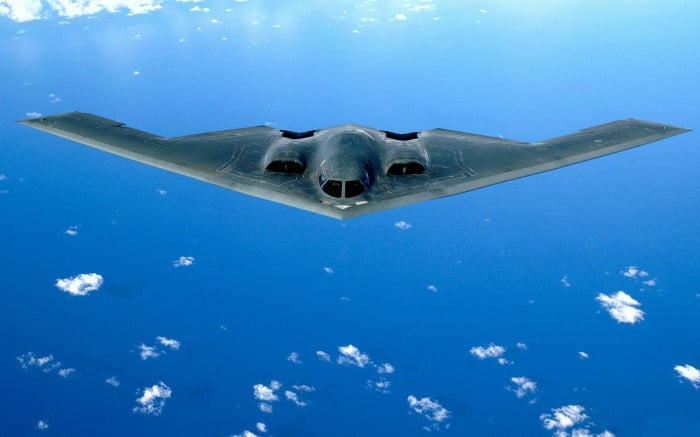

In [92]:
bomber_path = Path("cifar_data/SpSZG7Z.jpg")
bomber_pil: Image.Image = Image.open(str(bomber_path))
bomber_pil

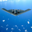

In [58]:
bomber_pil = bomber_pil.resize((32, 32), Image.Resampling.BICUBIC)
bomber_pil

In [69]:
bomber_t = cifar10_preprocessor(bomber_pil)
batch_t = torch.unsqueeze(bomber_t, 0)

In [73]:
model(batch_t), model_l1(batch_t), model_l2(batch_t), model_elnet(batch_t)

(tensor([[ 0.9344, -1.1910]], grad_fn=<AddmmBackward0>),
 tensor([[-0.0120, -0.9543]], grad_fn=<AddmmBackward0>),
 tensor([[ 0.9673, -0.9225]], grad_fn=<AddmmBackward0>),
 tensor([[ 0.4084, -0.4836]], grad_fn=<AddmmBackward0>))

For all the models, they predict that the image is an airplane. So far so good. What do the parameter values look like between the models?

In [87]:
def plot_params(mod):
    all_params = np.array([], dtype=np.float32)
    for p in mod.parameters():
        all_params = np.append(all_params, np.asarray(p.storage()))
    fig, ax = plt.subplots()
    fig: plt.Figure
    ax: plt.Axes
    ax.bar(range(len(all_params)), all_params)
    ax.grid(axis="y")
    ax.set_ylim(-0.25, 0.25)
    ax.set_xlabel("Parameter Number")
    ax.set_ylabel("Value")
    plt.show(fig)

## Default model without regularization

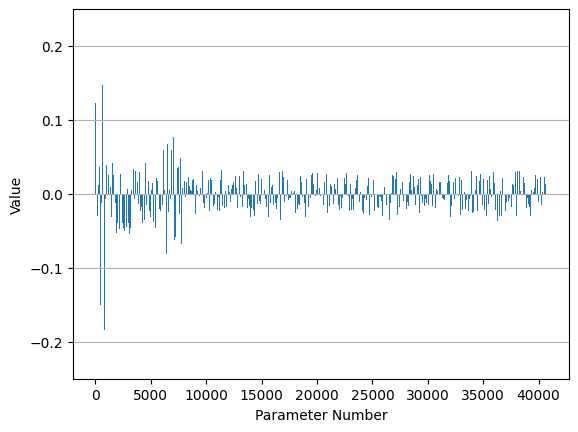

In [88]:
plot_params(model)

## Model with L2 "ridge" regularization

Compared to the default, there are not much different. There are more clusters of similar magnitude groups.

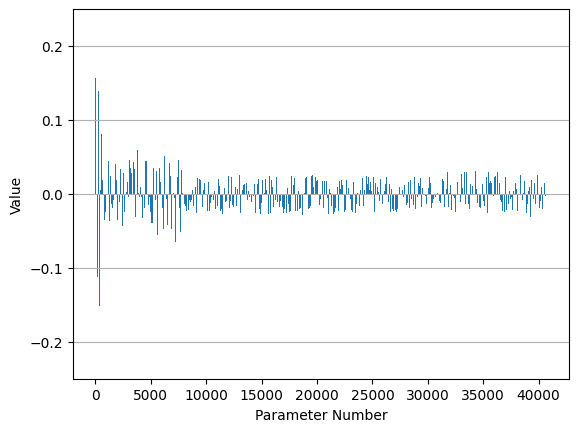

In [89]:
plot_params(model_l2)

## Model with L1 "lasso" regularization

More parameters are driven to zero and fewer values largely deviate from zero.

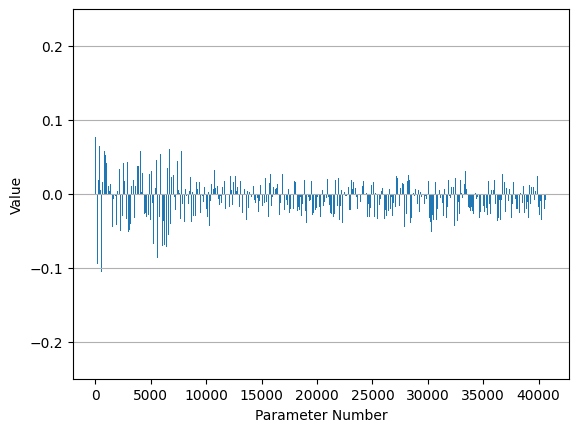

In [90]:
plot_params(model_l1)

## Model with L1+L2 "elastic net" regularization

Both L1 and L2 features are present where parameters are driven to zero while groups are driven to the similar magnitude.

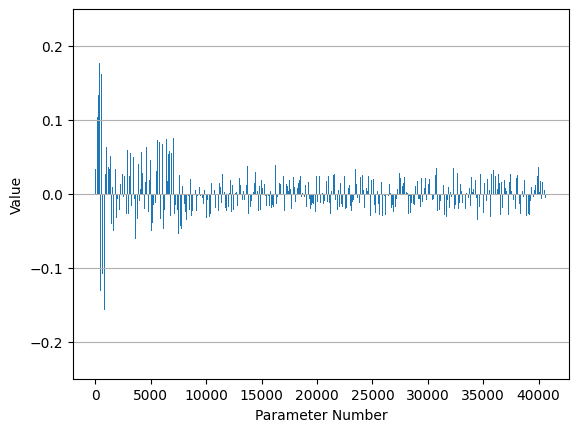

In [91]:
plot_params(model_elnet)